In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
plt.rcParams['text.usetex'] = False

# 加载机场数据库
db = pd.read_csv(f'datasets/airports.csv')
db.head(3)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN


In [2]:
# 加载数据
file_path = 'datasets/asos.csv'
data = pd.read_csv(file_path, skiprows=5)

# 转换日期列为日期时间格式
data['valid'] = pd.to_datetime(data['valid'])

# 转换能见度单位
data['vsby_km'] = data['vsby'] * 1.60934
data['vsby_nm'] = data['vsby'] * 0.868976

# 查询位置
data = data.merge(db[['gps_code', 'latitude_deg', 'longitude_deg', 'iso_country']], how='left', left_on='station', right_on='gps_code')
data = data[data.iso_country == 'CN']

# 平均能见度
vsby_km_mean = data[['station', 'vsby_km']].groupby('station').mean()

print(f'机场数: {data.station.value_counts().shape[0]}')
print(f'未匹配到: {data[data.gps_code.isna()].station.drop_duplicates()}')
data

机场数: 45
未匹配到: Series([], Name: station, dtype: object)


,station,valid,vsby,vsby_km,vsby_nm,gps_code,latitude_deg,longitude_deg,iso_country
0,ZBAD,2023-01-01 00:00:00,6.21,9.994001,5.396341,ZBAD,39.509945,116.410920,CN
1,ZBHH,2023-01-01 00:00:00,6.21,9.994001,5.396341,ZBHH,40.849658,111.824598,CN
2,ZBSJ,2023-01-01 00:00:00,6.21,9.994001,5.396341,ZBSJ,38.280701,114.696999,CN
3,ZBAA,2023-01-01 00:00:00,6.21,9.994001,5.396341,ZBAA,40.080101,116.584999,CN
4,ZBTJ,2023-01-01 00:00:00,6.21,9.994001,5.396341,ZBTJ,39.124401,117.346001,CN
...,...,...,...,...,...,...,...,...,...
454449,ZBAA,2023-12-30 23:30:00,6.21,9.994001,5.396341,ZBAA,40.080101,116.584999,CN
454450,ZWWW,2023-12-30 23:30:00,0.68,1.094351,0.590904,ZWWW,43.907101,87.474197,CN
454452,ZSPD,2023-12-30 23:30:00,1.37,2.204796,1.190497,ZSPD,31.143400,121.805000,CN
454453,ZSSS,2023-12-30 23:30:00,1.12,1.802461,0.973253,ZSSS,31.198104,121.334260,CN


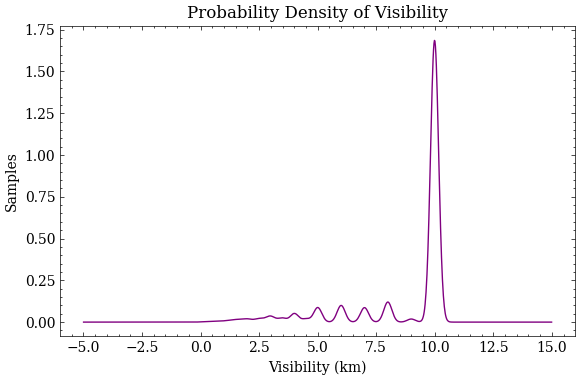

In [3]:
# 绘制能见度的概率密度图
plt.figure(figsize=(6, 4))
data['vsby_km'].plot(kind='density', color='purple')
plt.xlabel('Visibility (km)')
plt.ylabel('Samples')
plt.title('Probability Density of Visibility')
plt.tight_layout()
plt.savefig('figs/density_of_visibility', dpi=600, bbox_inches='tight')
plt.show()

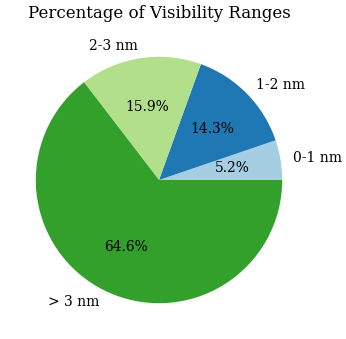

In [4]:
# 定义自定义区间
bins = [0, 1, 2, 3, data['vsby_nm'].max()]
labels = ['0-1 nm', '1-2 nm', '2-3 nm', '> 3 nm']
data['vsby_range_custom'] = pd.cut(data['vsby'], bins=bins, labels=labels, right=False)

# 计算每个区间的百分比
visibility_counts_custom = data['vsby_range_custom'].value_counts(normalize=True) * 100
visibility_counts_custom = visibility_counts_custom.sort_index()

# 绘制自定义区间的饼图
plt.figure(figsize=(6, 4))
visibility_counts_custom.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.ylabel('')
plt.title('Percentage of Visibility Ranges')
plt.show()

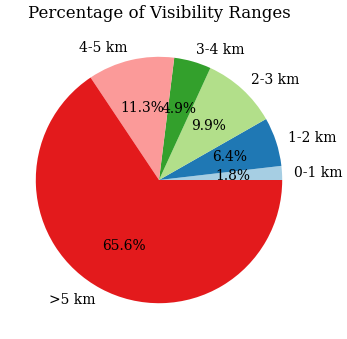

In [5]:
# 定义自定义区间
bins = [0, 1, 2, 3, 4, 5, data['vsby_km'].max()]
labels = ['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', '>5 km']
data['vsby_range_custom'] = pd.cut(data['vsby_km'], bins=bins, labels=labels, right=False)

# 计算每个区间的百分比
visibility_counts_custom = data['vsby_range_custom'].value_counts(normalize=True) * 100
visibility_counts_custom = visibility_counts_custom.sort_index()

# 绘制自定义区间的饼图
plt.figure(figsize=(6, 4))
visibility_counts_custom.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.ylabel('')
plt.title('Percentage of Visibility Ranges')
plt.savefig('figs/percentage_of_visibility_ranges', dpi=600, bbox_inches='tight')
plt.show()

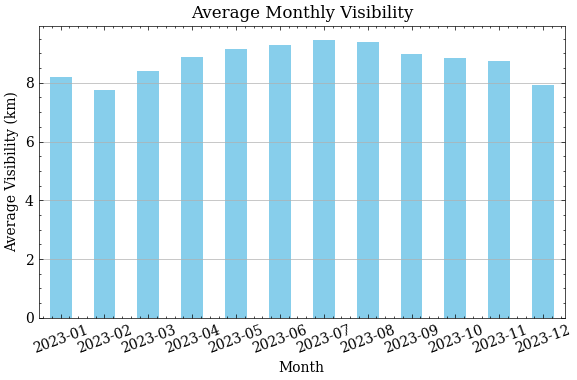

In [6]:
# 按月份分组计算能见度的平均值
data['month'] = data['valid'].dt.to_period('M')
monthly_visibility = data.groupby('month')['vsby_km'].mean()

# 绘制每月能见度平均值柱状图
plt.figure(figsize=(6, 4))
monthly_visibility.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Visibility (km)')
plt.title('Average Monthly Visibility')
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figs/average_monthly_visibilitys', dpi=600, bbox_inches='tight')
plt.show()

In [7]:
import numpy as np
from pyecharts.charts import Geo
from pyecharts import options as opts
from pyecharts.globals import GeoType

# 创建 Geo 实例
geo = Geo(
    init_opts=opts.InitOpts(
        width="500px", height="450px", bg_color="white",
        theme="light", renderer="svg"
    )
)

# 添加地图
geo.add_schema(maptype="china", zoom=1.2, is_roam=False)

# 添加机场位置
for _, row in data.drop_duplicates(subset='gps_code').iterrows():
    geo.add_coordinate(row['gps_code'], row['longitude_deg'], row['latitude_deg'])

# 绘制标记点
# 训练集
data_pair = [(z) for z in zip(data.drop_duplicates(subset='station').gps_code, np.ones(data.shape[0]))]
geo.add(
    "Airports",
    data_pair,
    type_=GeoType.SCATTER,
    symbol_size=6,
)

# 参数设置
geo.set_series_opts(
    label_opts=opts.LabelOpts(is_show=False)
)
geo.set_global_opts(
    legend_opts=opts.LegendOpts(
        pos_top='bottom',
        pos_left='left',
        orient='vertical',
        background_color='white',
        textstyle_opts=opts.TextStyleOpts(
            font_family='Times New Roman', font_size=13)
    )
)

def add_download_link(path):
    # 增加下载svg的链接
    code_to_insert = """
    <a id="download" href="">下载</a>
    <script>
    const a = window.document.querySelector('#download')
    a.addEventListener('click',()=>{
        const content = document.querySelector('svg').outerHTML
        const blob= new Blob([content], {type: 'xml/svg'})
        a.href = URL.createObjectURL(blob)
        a.download = 'test.svg'
    })
    </script>
    """
    with open(path, "r", encoding="utf-8") as file:
        html_content = file.read()

    insert_position = html_content.find("</body>")
    if insert_position != -1:
        new_html_content = html_content[:insert_position] + \
            code_to_insert + html_content[insert_position:]
        with open(path, "w", encoding="utf-8") as file:
            file.write(new_html_content)
    else:
        print("Could not find </body> tag in the HTML file.")

# 显示图表
path = 'figs/airport_map.html'
geo.render(path)
add_download_link(path)
geo.render_notebook()
